# Task
Добавляю к базовому варианту использование порога вероятности и PR-curve

Задача: Поднять значение метрики Precision

# Import modules

In [87]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

import Handlers as hd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

from sklearn.model_selection import train_test_split # сплитование выборки
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder, BinaryEncoder

from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

from sklearn import set_config
set_config(transform_output='pandas')

%matplotlib inline
plt.style.use('seaborn-darkgrid')
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10, 8)

# Load Data

In [89]:
data = pd.read_parquet('..\ETH-Full-1H.parquet')

In [90]:
df = data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49337 entries, 2017-09-01 00:00:00 to 2023-04-23 23:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    49337 non-null  float64
 1   High    49337 non-null  float64
 2   Low     49337 non-null  float64
 3   Close   49337 non-null  float64
 4   Volume  49337 non-null  float64
 5   Trades  49337 non-null  int32  
dtypes: float64(5), int32(1)
memory usage: 2.4 MB


In [91]:
df

,Open,High,Low,Close,Volume,Trades
Datetime,,,,,,
2017-09-01 00:00:00,384.79,388.74,384.79,388.74,162.97779,131
2017-09-01 01:00:00,388.69,394.06,387.53,391.37,248.72949,262
2017-09-01 02:00:00,392.88,394.39,389.46,390.88,198.82856,225
2017-09-01 03:00:00,391.70,393.13,390.86,390.86,141.56114,138
2017-09-01 04:00:00,392.65,394.27,387.64,390.33,135.65894,128
...,...,...,...,...,...,...
2023-04-23 19:00:00,1846.76,1852.35,1844.92,1846.49,16550.18290,21648
2023-04-23 20:00:00,1846.49,1852.30,1838.03,1848.89,13113.47550,19445
2023-04-23 21:00:00,1848.88,1859.32,1847.59,1854.66,7855.61330,13824


# Base Visualization

In [92]:
# # If need to plot not all data
# # df_to_plot = df[df.index >= '2018-01-01']
# df_to_plot = df

# # Create a 2-row, 1-column subplot grid
# fig, ax = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

# # Convert series to numpy
# ind = df_to_plot.index.to_numpy()
# _0 = df_to_plot['Close'].to_numpy()
# _1 = df_to_plot['Volume'].to_numpy()
# _2 = df_to_plot['Trades'].to_numpy()

# ax[0].plot(ind, _0, linewidth=1)
# ax[0].set_title('Close')

# ax[1].fill_between(ind, _1, step='pre')
# ax[1].set_title('Volume')

# ax[2].fill_between(ind, _2, step='pre')
# ax[2].set_title('Trades')

# # Set the x-axis label for the entire figure
# plt.xlabel('Date')

# # Adjust the layout and show the plot
# plt.tight_layout()
# plt.show()

В 17 году совсем маленькие объемы, подрежу данные. Не буду брать то что до 18 года

In [93]:
df = df[df.index >= '2018-01-01'].copy()

### Провека всех признаков исходного ряда на стационарность

In [94]:
# for col_name, col_data in df.items():
#     print("Column Name : ", col_name)
#     hd.adf(col_data.values)
#     print()

Volume, Trades стационарны и то, значения пограничные. Надо преобразовывать.

# Feature Enginiring
Логарифмирую все признаки

In [95]:
cols = df.columns
for col in cols:
    df[col + '_log'] = np.log(df[col])

df.drop(columns=cols, inplace=True) # удаляю все старые признаки

In [96]:
df

,Open_log,High_log,Low_log,Close_log,Volume_log,Trades_log
Datetime,,,,,,
2018-01-01 00:00:00,6.597159,6.599217,6.579293,6.589779,7.652499,8.043663
2018-01-01 01:00:00,6.588940,6.595781,6.574797,6.576428,7.743257,7.963808
2018-01-01 02:00:00,6.576010,6.587206,6.575898,6.584860,7.680849,7.991931
2018-01-01 03:00:00,6.584722,6.603930,6.582994,6.599190,7.678282,8.201660
2018-01-01 04:00:00,6.599857,6.613357,6.593058,6.613143,7.755912,8.163941
...,...,...,...,...,...,...
2023-04-23 19:00:00,7.521188,7.524210,7.520191,7.521042,9.714152,9.982668
2023-04-23 20:00:00,7.521042,7.524183,7.516450,7.522341,9.481396,9.875345
2023-04-23 21:00:00,7.522335,7.527966,7.521637,7.525457,8.968984,9.534161


Тени от открытия бара на лог шкале

In [97]:
df['Low_Shad_log'] = df['Open_log'] - df['Low_log']
df['High_Shad_log'] = df['High_log'] - df['Open_log']

Прирост за бар на лог шкале

Фактически это аналог first log difference

Прирост и тени от открытия бара, т.к. в истории есть пропуски по много часов и они могут давать сильные искажения, вылеты для таргетов

In [98]:
df['Log_Return'] = df['Close_log'] - df['Open_log']

# Create Target Category Feature 
Создаю целевой признак

Это фактически очередные гиперпараметры.

Я могу задавать уровень риска в лог величинах - risk_level

и коэффициент доходность/риск в виде множителя - risk_factor

Т.е. текущий случай это:
* risk_level = 0.0025
* risk_factor = 4

In [99]:
risk_level = 0.0025
profit_factor = 4
profit_level = risk_level * profit_factor
TARGET = 'Long'

In [100]:
zero_mo = hd.profit_margin_for_zero_mo(risk_level, profit_factor)
print('Метрика Precision должна быть выше:', zero_mo)

Метрика Precision должна быть выше: 0.2


In [101]:
df[TARGET] = np.where((df['High_Shad_log'] >= profit_level) & (df['Low_Shad_log'] <= risk_level), 1, 0)

Анализ распределения классов целевого признака

In [102]:
class_df = pd.DataFrame({'%': (df[TARGET].value_counts(True) * 100).round(2), 'Count': df[TARGET].value_counts()})
class_df.index.name = 'Class'
class_df.sort_index(ascending=False, inplace=True)
class_df
    

,%,Count
Class,,
1,9.16,4252
0,90.84,42164


# Feature Engineering
* Преобразую исходные данные
* Получаю новые признаки. 
* Удаляю ненужные.
* Обогощаю данные.

* Объемы и сделки:
Можно считать средний объем сделки. 
- AvrTrade = Volume / Trades
- Объем в долларах, т.е. нормированный объем VolUSD = Volume * Close
- Объем на единицу диапазона.

### Базовая модель - оставляю в качестве признака только Log_Return и целевой признак

In [103]:
df_new = df[['Log_Return', TARGET]].copy()

# Transform TimeSeries to Dataset for Supervised Learning
Тут определяется глубина последовательности данных, которая будет использоваться для построения прогноза T. Временное окно в прошлое.

Т это так же гиперпараметр, его так же нужно будет искать по сетке.

In [104]:
T = 12 # len of sequence. Num of time steps to look at to make prediction on next step

Create $X$, $y$

In [105]:
X, y = hd.create_X_y_from_timeseries(df_new, TARGET, T)

In [106]:
print('X.shape:', X.shape, 'y.shape:', y.shape)

X.shape: (46404, 12) y.shape: (46404,)


# Split Data
Разбиение с стратифиацией

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

In [108]:
X_train

array([[ 0.01431639,  0.01328936,  0.04597455, ...,  0.00182127,
         0.01297155,  0.00649456],
       [ 0.00623582,  0.00289642,  0.02068179, ...,  0.01096051,
        -0.00886201,  0.00922931],
       [-0.00237889,  0.00358445, -0.00154682, ...,  0.00204782,
        -0.00050087,  0.00274561],
       ...,
       [-0.00660384,  0.00991469,  0.00171508, ...,  0.00131963,
        -0.00170484, -0.00709801],
       [ 0.0092561 , -0.01115772,  0.00220154, ..., -0.0133019 ,
         0.00569589,  0.00269655],
       [-0.01004721,  0.0009625 , -0.00494408, ...,  0.01158179,
        -0.00674922,  0.00099756]])

# Outliers
Обработка выбросов. Пробовать прорядить выборку удалением записей по методу:
- 3х сигм
- методу Тьюки
- Isolation Forest
- Local Outlier Factor
- Minimun Covariance Determinant

Но обработку надо делать уже после разделения выборки на train/test

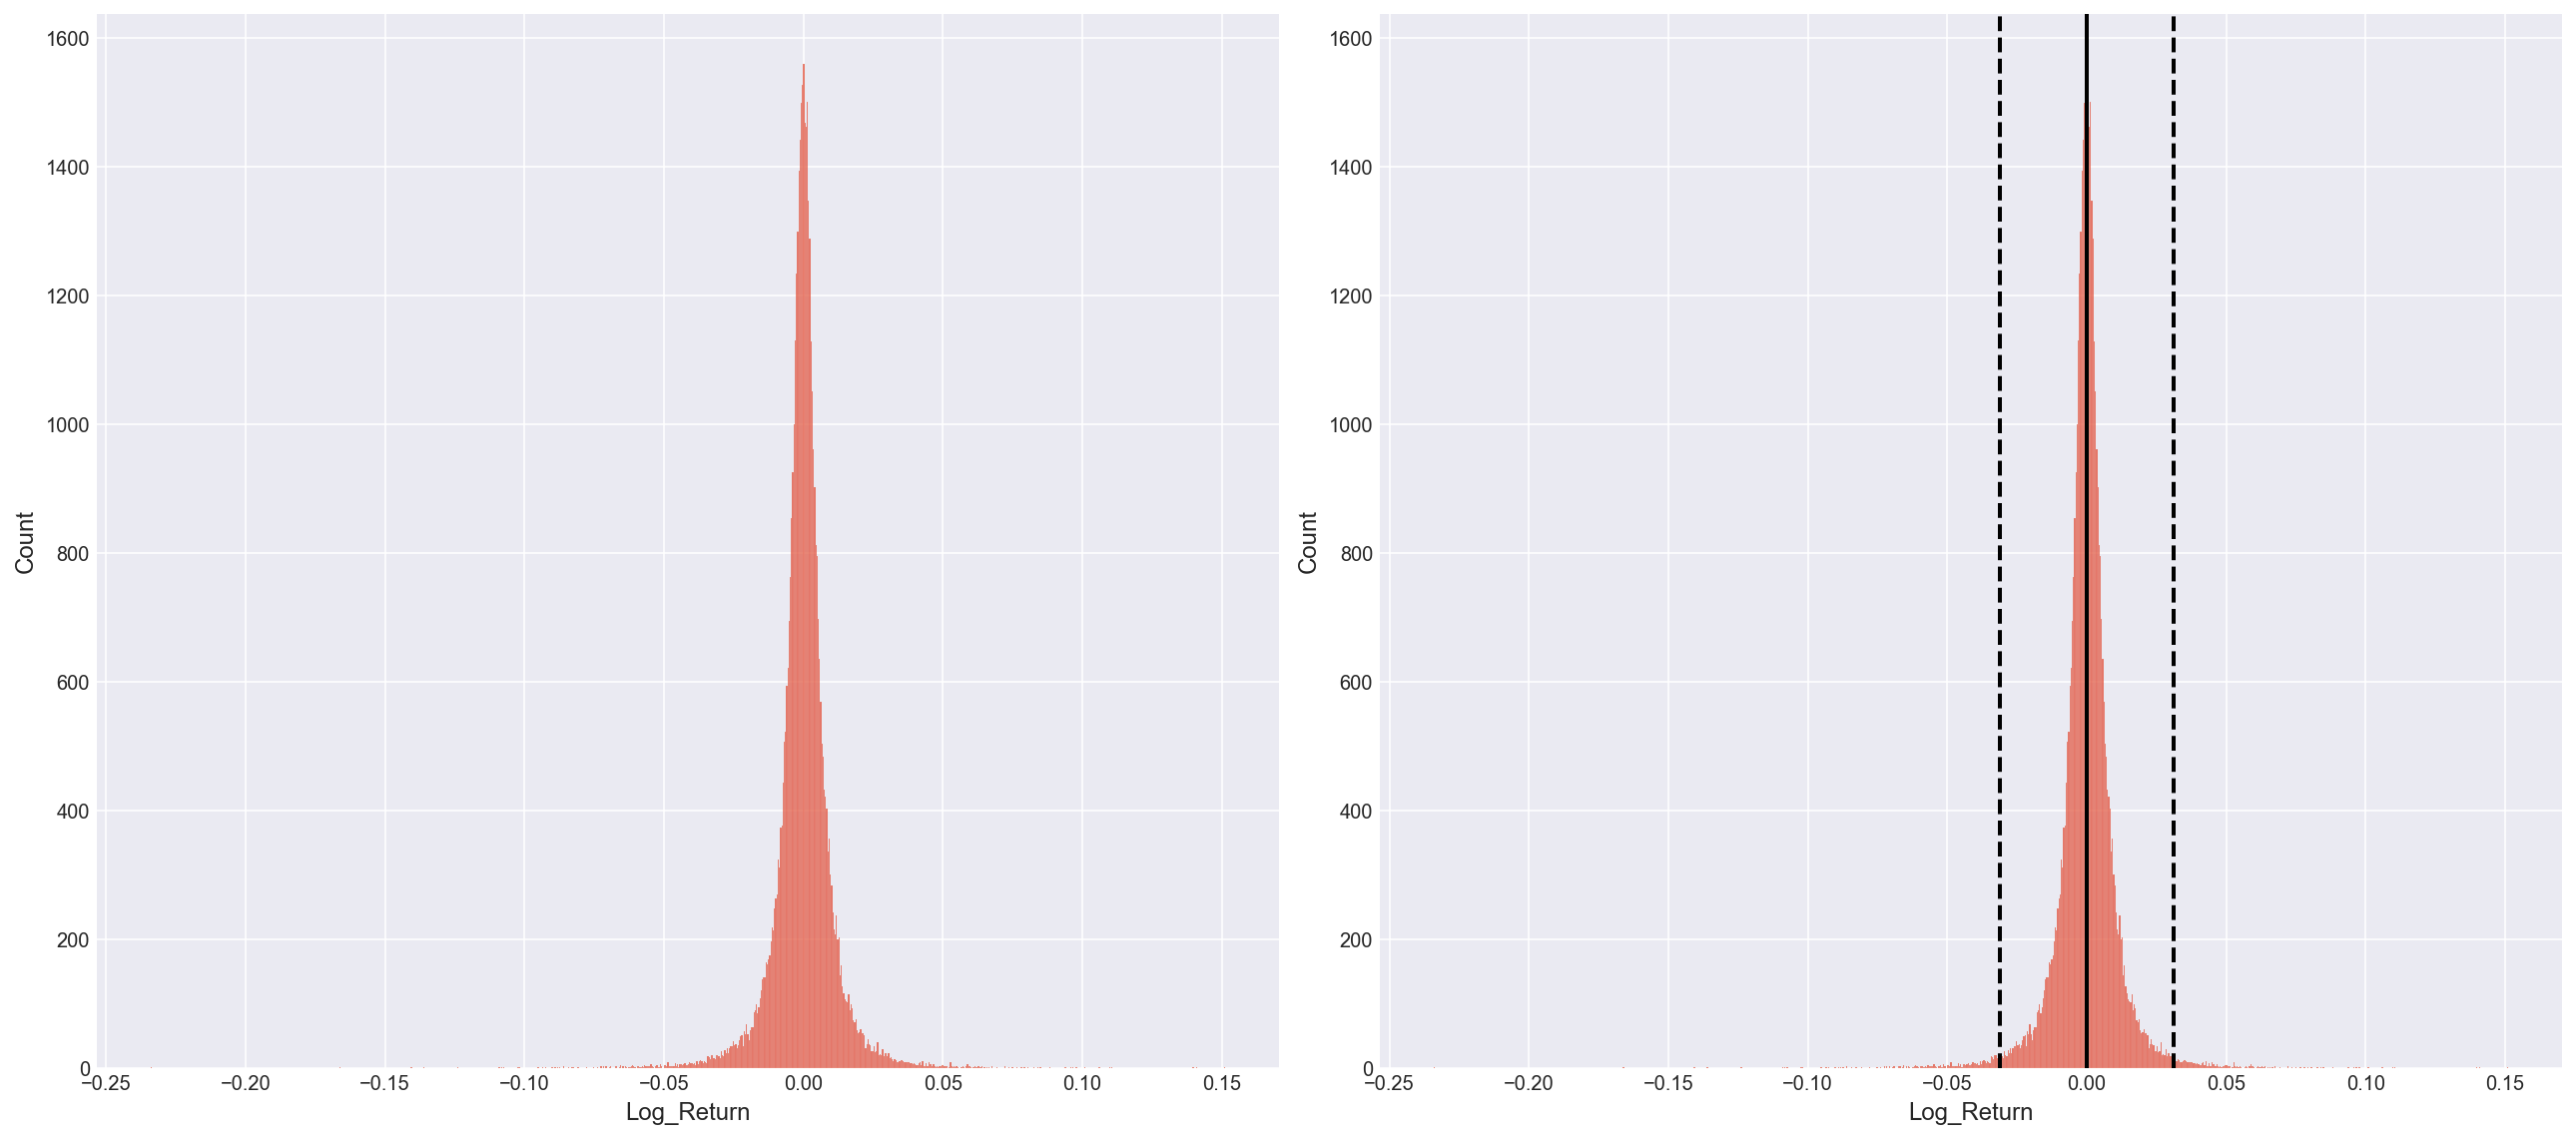

In [109]:
hd.plot_outliers_z_score(df_new, 'Log_Return', log_scale=False) # log_scale=False т.к. цены были изначально прогалорифмированы и затем еще и разница посчитана

Распределение выглядит максимально равномерно. 
Позже, на последующих итерациях можно думать о том, что бы обрезать хвосты и посмотреть как это отразится на результатах модели.

# Scaling Data
Нужно скалировать признаки, приводить их к одному масштабу. Путем перебора выбирать лучший скалер.

In [110]:
# scaler = StandardScaler()

# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Create Model

In [111]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [112]:
hd.print_classification_metrics(y_train, y_train_pred, y_test, y_test_pred)

*** TRAIN ***
Accuracy: 0.532
Precision: 0.103
Recall: 0.535
F1: 0.173

*** TEST ***
Accuracy: 0.525
Precision: 0.102
Recall: 0.539
F1: 0.172


In [113]:
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

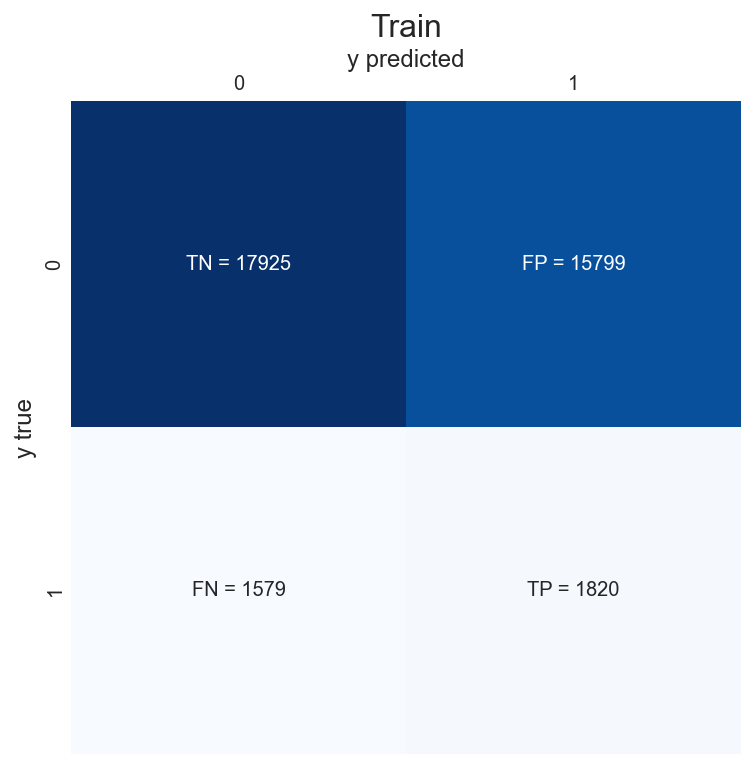

In [114]:
hd.plot_confusion_matrix(cm_train, 'Train')

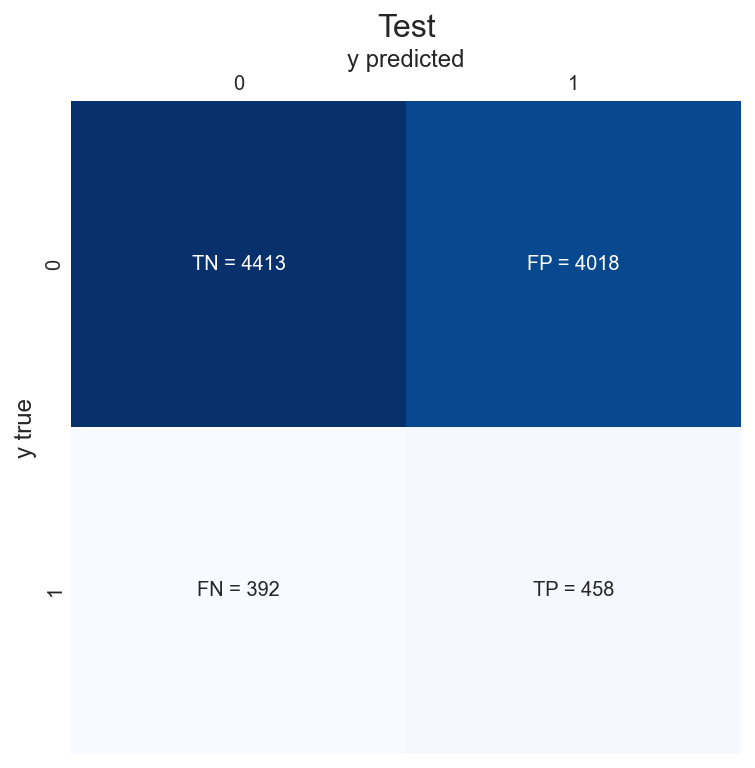

In [115]:
hd.plot_confusion_matrix(cm_test, 'Test')

Реальное распределение классов на тестовой выборке

In [116]:
pd.Series(y_test).value_counts()

0.0    8431
1.0     850
Name: count, dtype: int64

Прогнозное распределение классов на тестовой выборке

In [117]:
pd.Series(y_test_pred).value_counts()

0.0    4805
1.0    4476
Name: count, dtype: int64

Видно, что я очень много предсказываю класс 1, надо сильно меньше. Нужно на Precision фокусироваться.

Вот такая базовая модель.

Precision 0.101. Т.е. точность всего 10%.

*** TRAIN ***
Accuracy: 0.531
Precision: 0.104
Recall: 0.540
F1: 0.174

*** TEST ***
Accuracy: 0.528
Precision: 0.101
Recall: 0.524
F1: 0.169

### Настройка порога вероятности для логистической регрессии

In [118]:
# Тут берем таблицу вероятностей и интересует только вероятность класса 1 (второй столбец)
y_proba_pred = lr.predict_proba(X_test)[:, 1]

# Для удобства завернем numpy-массив в pandas Series
y_proba_pred = pd.Series(y_proba_pred)

# Создадим списки, в которых будем хранить значения метрик
precision_scores = []
recall_scores = []
f1_scores = []

# Сгенерируем набор вероятностных порогов в диапазоне от 0.05 до 1
thresholds = np.arange(0.3, 0.7 + 0.01, 0.01)

# В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    # Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    # В противном случае - к классу 0
    y_pred = y_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    
    # Считаем метрики и добавляем их в списки
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\avvoy\AppData\Local\Pr

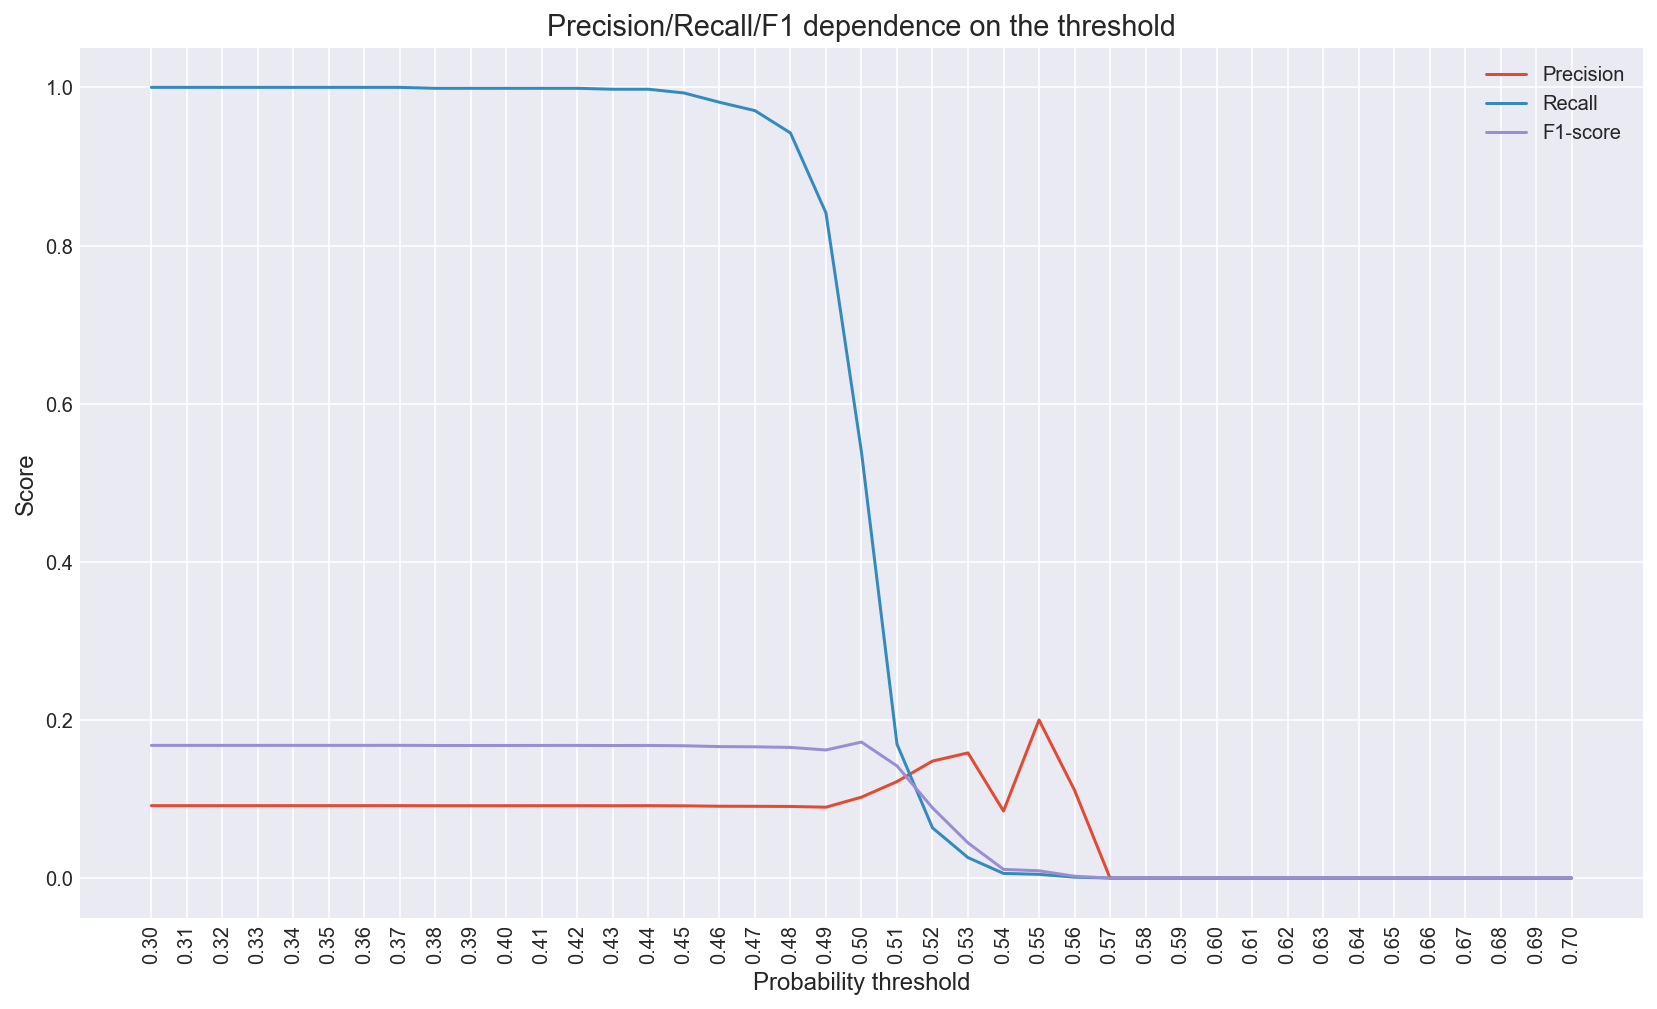

In [119]:
# Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(14, 8)) # фигура + координатная плоскость
# Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')
# Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
# Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')

# Даем графику название и подписи осям
ax.set_title('Precision/Recall/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
# Устанавливаем отметки по оси x
ax.set_xticks(thresholds)
ax.tick_params(axis='x', labelrotation=90)
# Отображаем легенду
ax.legend();

Выбираю значением пересечение кривых

In [120]:
# Задаем оптимальный порог вероятностей для максимизации Precision
threshold_opt = 0.512

y_pred_opt = y_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
# Считаем метрики
print(classification_report(y_test, y_pred_opt))

              precision    recall  f1-score   support

         0.0       0.91      0.90      0.91      8431
         1.0       0.13      0.14      0.13       850

    accuracy                           0.83      9281
   macro avg       0.52      0.52      0.52      9281
weighted avg       0.84      0.83      0.84      9281



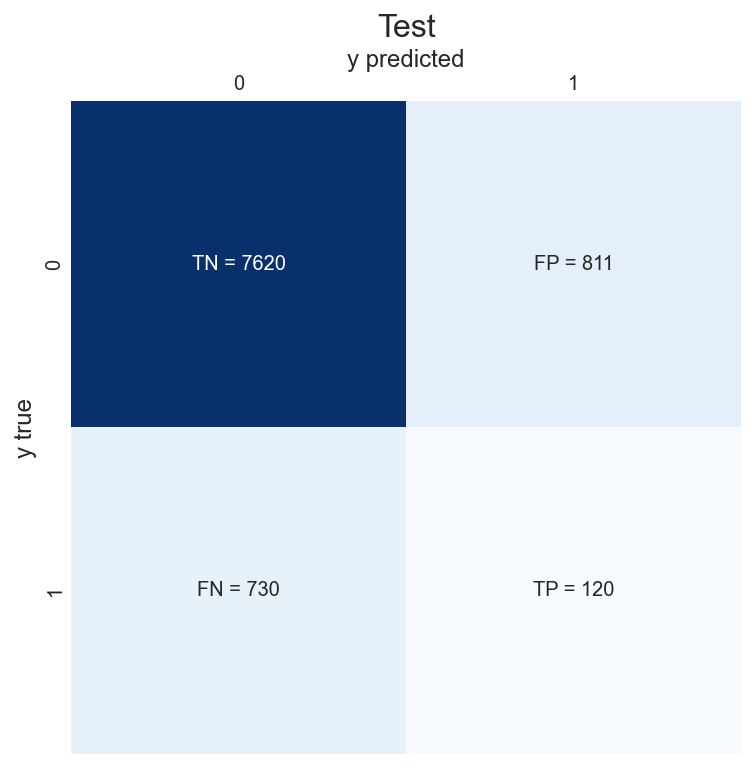

In [121]:
cm_test = confusion_matrix(y_test, y_pred_opt)
hd.plot_confusion_matrix(cm_test, 'Test')

# Случайный лес
подбор параметров вручную

In [82]:
rf = RandomForestClassifier(n_estimators=500, max_depth=5, min_samples_leaf=5, class_weight='balanced')
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
hd.print_classification_metrics(y_train, y_train_pred, y_test, y_test_pred)

*** TRAIN ***
Accuracy: 0.602
Precision: 0.141
Recall: 0.659
F1: 0.233

*** TEST ***
Accuracy: 0.575
Precision: 0.121
Recall: 0.582
F1: 0.201


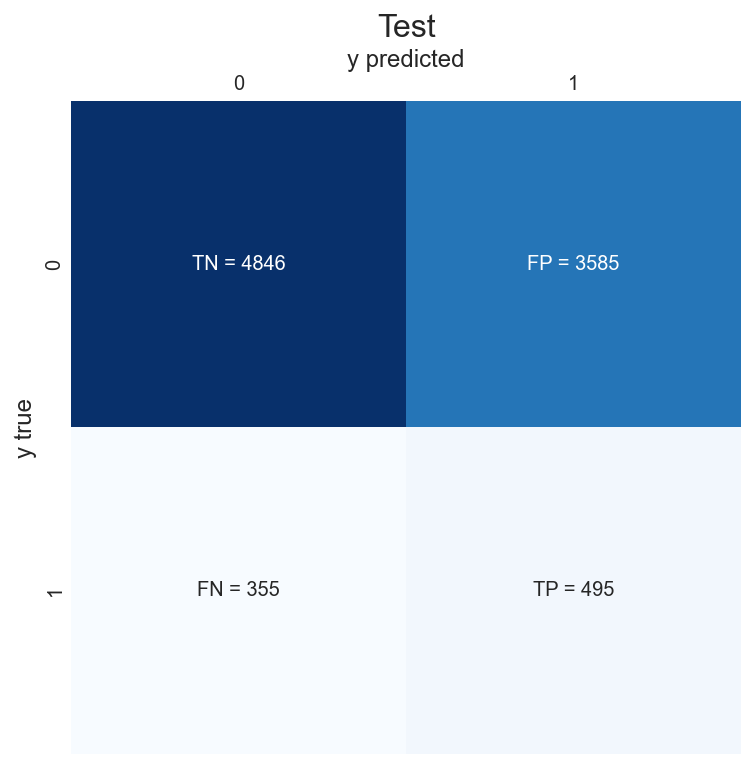

In [83]:
cm_test = confusion_matrix(y_test, y_test_pred)
hd.plot_confusion_matrix(cm_test, 'Test')

### Настройка порога вероятности для случайного леса

In [84]:
# Тут берем таблицу вероятностей и интересует только вероятность класса 1 (второй столбец)
y_proba_pred = rf.predict_proba(X_test)[:, 1]

# Для удобства завернем numpy-массив в pandas Series
y_proba_pred = pd.Series(y_proba_pred)

# Создадим списки, в которых будем хранить значения метрик
precision_scores = []
recall_scores = []
f1_scores = []

# Сгенерируем набор вероятностных порогов в диапазоне от 0.05 до 1
thresholds = np.arange(0.3, 0.7 + 0.01, 0.01)

# В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    # Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    # В противном случае - к классу 0
    y_pred = y_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    
    # Считаем метрики и добавляем их в списки
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\avvoy\AppData\Local\Pr

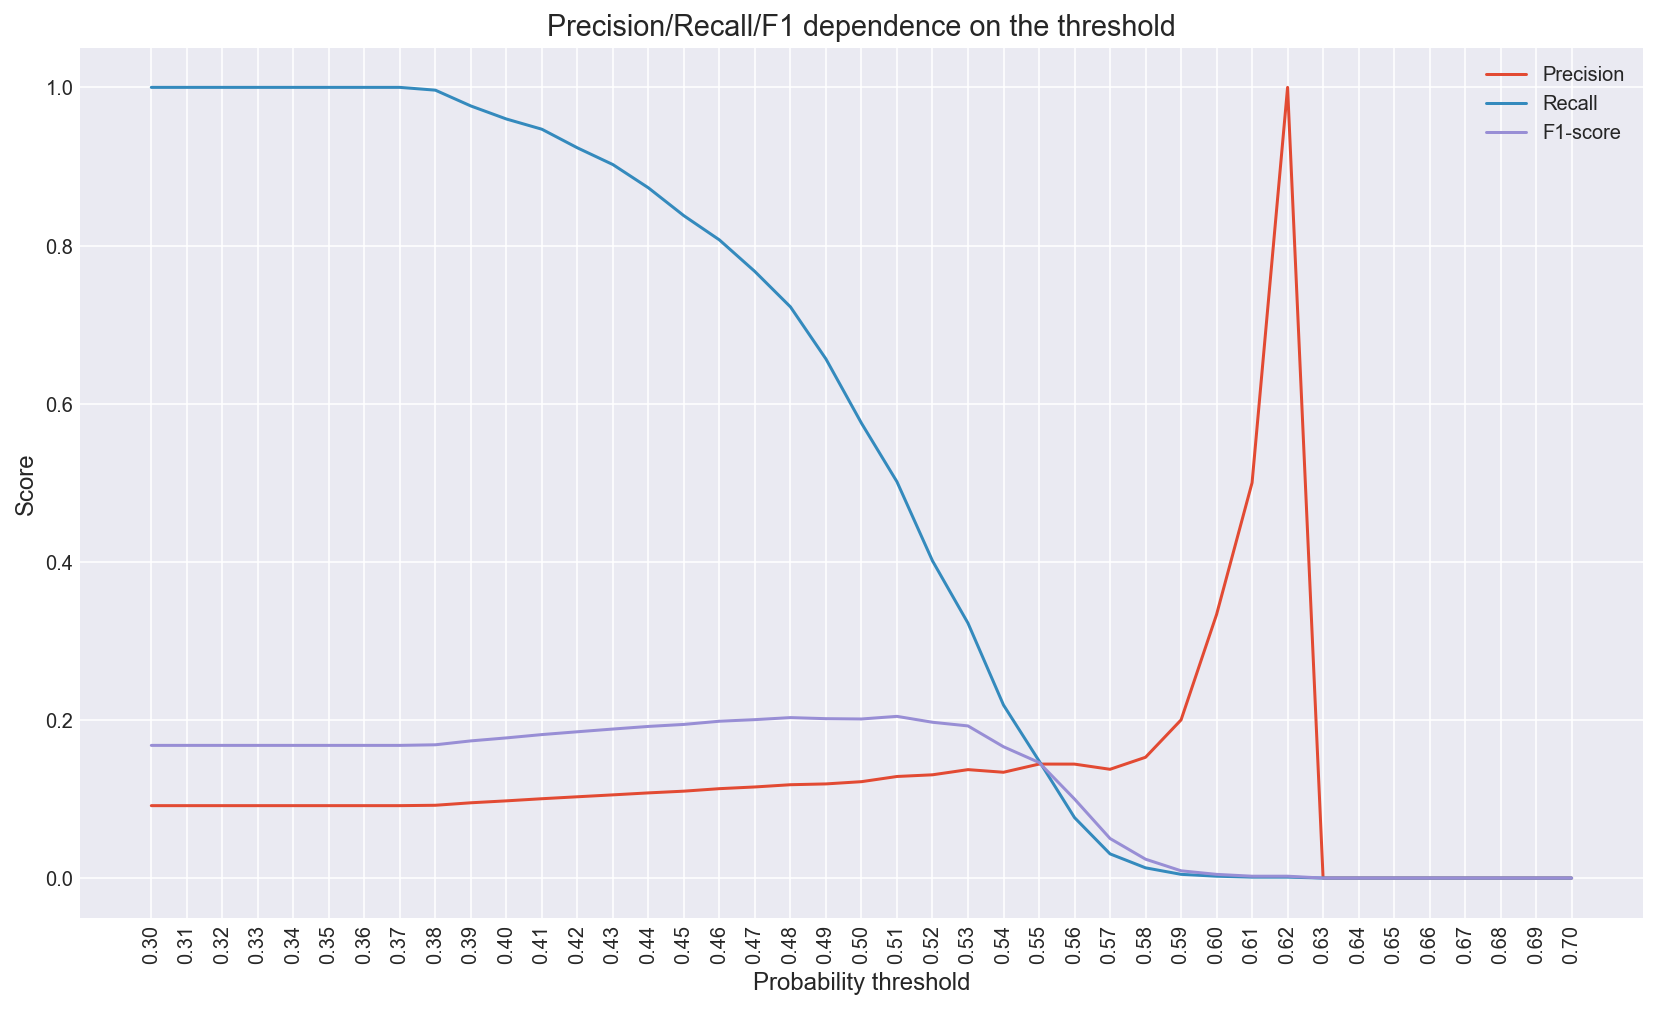

In [78]:
# Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(14, 8)) # фигура + координатная плоскость
# Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')
# Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
# Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')

# Даем графику название и подписи осям
ax.set_title('Precision/Recall/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
# Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
ax.tick_params(axis='x', labelrotation=90)
# Отображаем легенду
ax.legend();

Логичным выглядит пересечение всех кривых

In [85]:
# Задаем оптимальный порог вероятностей для максимизации Precision
threshold_opt = 0.55

y_pred_opt = y_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
# Считаем метрики
print(classification_report(y_test, y_pred_opt))

              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      8431
         1.0       0.14      0.15      0.15       850

    accuracy                           0.84      9281
   macro avg       0.53      0.53      0.53      9281
weighted avg       0.84      0.84      0.84      9281



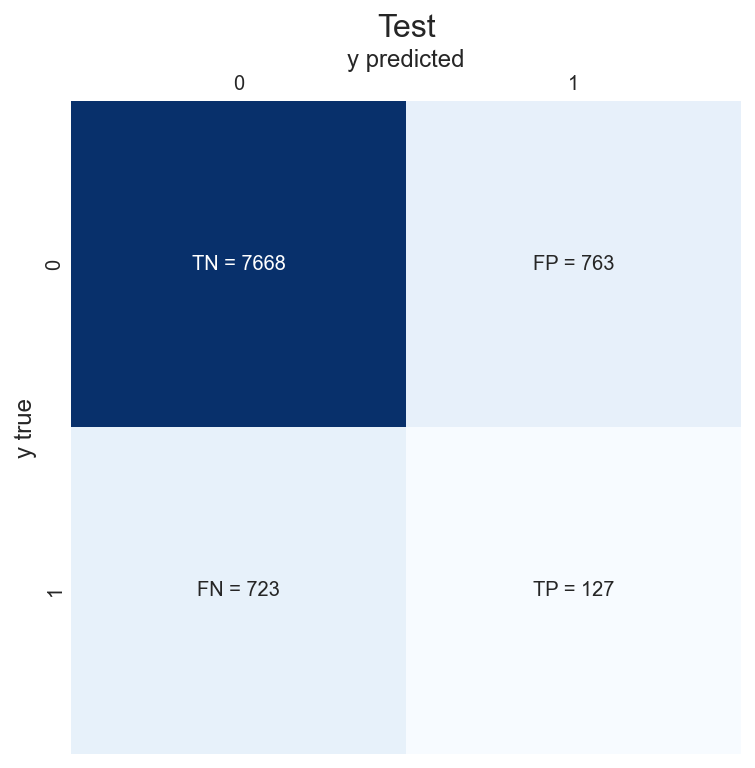

In [86]:
cm_test = confusion_matrix(y_test, y_pred_opt)
hd.plot_confusion_matrix(cm_test, 'Test')

Precision вырос до 14%, сделок стало сильно меньше.